In [1]:
devtools::install_github("clairbarnes/rwwa")
library(rwwa)

Skipping install of 'rwwa' from a github remote, the SHA1 (0707feb5) has not changed since last install.
  Use `force = TRUE` to force installation

Loading required package: extRemes

Loading required package: Lmoments

Loading required package: distillery


Attaching package: ‘extRemes’


The following objects are masked from ‘package:stats’:

    qqnorm, qqplot


Loading required package: plyr


Attaching package: ‘plyr’


The following object is masked from ‘package:distillery’:

    is.formula




# Fitted trend in temperature maxima

In [4]:
gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2024]

# fit all the models
models <- sapply(list.files("ts", pattern = "sahel-heat", full.names = T), function(fnm) {
    
    df <- merge(gmst, load_ts(fnm, col.names = c("year", "tas")))
    fit_ns("gev", "shift", df, "tas", c("gmst"), lower = F)    
    
}, simplify = F)

In [5]:
# bootstrap all the parameter estimates

for( mnm in names(models)) {
    mdl <- models[[mnm]]
    res <- boot_ci(mdl, cov_f = data.frame(gmst = 0), cov_cf = data.frame(gmst = -1.2), nsamp = 1000)
    write.csv(res, gsub(".dat", ".csv", gsub("ts/", "res/res_", mnm)))
}

## Parameter estimates

In [17]:
# load all the bootstrapped results
res_apr <- abind::abind(sapply(list.files("res", pattern = "sahel-heat.+april_-", full.names = T), read.csv, row.names = "X", simplify = F), along = 0)
res_mam <- abind::abind(sapply(list.files("res", pattern = "sahel-heat.+mam_-", full.names = T), read.csv, row.names = "X", simplify = F), along = 0)

res_apr[!is.finite(res_apr)] <- NA
res_mam[!is.finite(res_mam)] <- NA

In [18]:
res_apr[,"return_period",]
res_mam[,"return_period",]

,est,X2.5.,X97.5.
res/res_sahel-heat_tn3x-april_-10_20_10_17_mswx.csv,2.502777,1.659588,4.811920
res/res_sahel-heat_tn5x-april_-10_20_10_17_mswx.csv,2.549337,1.650666,5.257266
res/res_sahel-heat_tx3x-april_-10_20_10_17_mswx.csv,10.509244,5.899139,96.974646
res/res_sahel-heat_tx5x-april_-10_20_10_17_mswx.csv,22.740676,9.180245,NA


,est,X2.5.,X97.5.
res/res_sahel-heat_tn3x-mam_-10_20_10_17_mswx.csv,1.250766,1.078500,1.534123
res/res_sahel-heat_tn5x-mam_-10_20_10_17_mswx.csv,1.192268,1.033983,1.466368
res/res_sahel-heat_tx3x-mam_-10_20_10_17_mswx.csv,10.890789,5.182768,397.032983
res/res_sahel-heat_tx5x-mam_-10_20_10_17_mswx.csv,24.087681,6.940679,NA


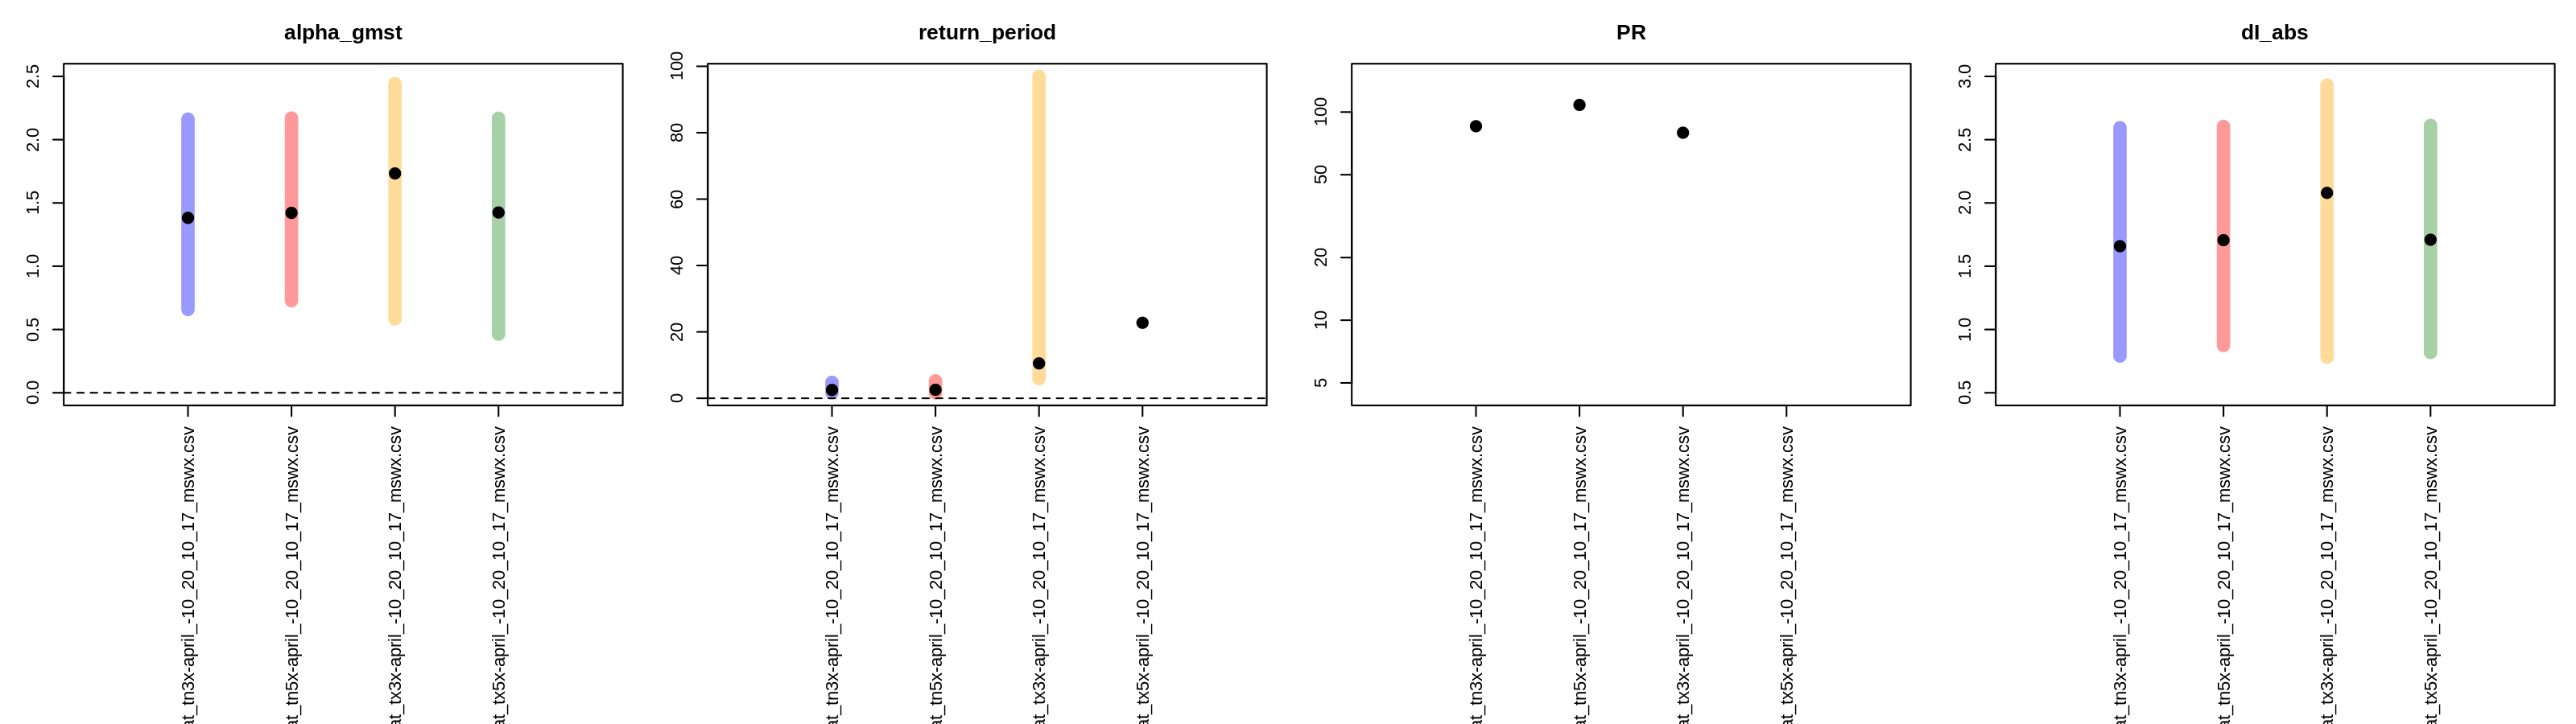

In [19]:
all_res <- res_apr
plot_pars <- c("alpha_gmst", "return_period", "PR", "dI_abs")
prep_window(c(1,4), h = 4.5); par(mar = c(15,3,3,1))

    par(mfrow = c(1,length(plot_pars)))

    for (r in plot_pars) {
        res <- all_res[,r,]
        ylim = range(res, na.rm = T)
        logaxs = ""
        h = 0
        
        n <- nrow(res)
        if(grepl("alpha", r)) {
            ylim = range(pretty(all_res[,grepl("alpha", colnames(all_res)),]))
        } else if(grepl("dI_abs", r)) {
            ylim = range(pretty(all_res[,grepl("dI_abs", colnames(all_res)),]))
        } else if(grepl("dI_rel", r)) {
            ylim = range(pretty(all_res[,grepl("dI_rel", colnames(all_res)),]))
        } else if(grepl("PR", r)) {
            h = 1
            logaxs = "y"
            ylim = exp(range(pretty(log(all_res[,grepl("PR", colnames(all_res)),]))))
        }
        
        plot(1, type = "n", ylim = ylim, xlim = c(0,n+1), main = r, xaxt = "n", xlab = "", ylab = "", log = logaxs)
        axis(1, at = 1:n, labels = rownames(res), las = 2)
        segments(x0 = 1:n, y0 = res[,"X2.5."], y1 = res[,"X97.5."], lwd = 8, col = adjustcolor(c("blue", "red", "orange", "forestgreen", "chartreuse3", "chartreuse3"), alpha = 0.4))
        points(1:n, res[,"est"], pch = 20, cex = 2)
        abline(h = h, lty = 2)
    }